<a href="https://colab.research.google.com/github/Seife1/PRODIGY_ML_04/blob/main/Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hand Gesture Recognition**

## **Data Overview**

The data is extracted and aggregated from [kaggle](https://www.kaggle.com/datasets/gti-upm/leapgestrecog). The database is composed by 10 different hand-gestures that were performed by 10 different subjects (5 men and 5 women).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [2]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# To display the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Randomizer
import random

# OS
import os

# Image package
from PIL import Image

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
# Importing Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential                          # Neural network model as a sequence of layers.
from tensorflow.keras.layers import Conv2D                              # Convolutional layer
from tensorflow.keras.layers import MaxPooling2D                        # Max pooling layer
from tensorflow.keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from tensorflow.keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from tensorflow.keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from tensorflow.keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from tensorflow.keras.layers import Activation                          # Layer for activation functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from tensorflow.keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [4]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In [5]:
# import zipfile

# # Define the path to your zip file
# file_path = '/content/drive/MyDrive/kaggle/hand-gesture-recognition.zip'

# # Unzip the file to a specific destination
# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/ProdigyInfoTech')

In [9]:
# Loading hand gesture directories Colab Notebooks/ProdigyInfoTech/
base_path = '/content/drive/MyDrive/leapGestRecog'

The database is structured in different folders as:
* /00  /01  /02  /03  /04  /05  /06  /07  /08  /09.

Every folder (00, 01,…) contains the infrared images of one subject. The folder name is the identifier of each different subject.
* 01_palm
* 02_l
* 03_fist
* 04_fist_moved
* 05_thumb
* 06_index
* 07_ok
* 08_palm_moved
* 09_c
* 10_down

In [10]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6F7'

## Loading the data

In [11]:
folder_names = []
labels = []
gesture_folders = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
               '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
label_map = {gesture: num for num, gesture in enumerate(gesture_folders)}

for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)
        if os.path.isdir(subject_path):
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)
                if os.path.isdir(gesture_path):
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        labels.append(label_map[gesture])
                        folder_names.append(subject)

## Data Understanding

In [12]:
# Counting the total of pictures inside each subfolder and directory
print('\n* * * * * Number of files in each folder * * * * *\n')

for subject in os.listdir(base_path):
  subject_path = os.path.join(base_path, subject)
  if os.path.isdir(subject_path):
    total = 0
    for sub in gesture_folders:
      path = os.path.join(subject_path, sub)
      num_files = len([f for f in (os.listdir(path)) if os.path.join(path, f)])
      total += num_files
      print(f'\n{subject}/{sub}: {num_files}')
  print(f'\nThere are {total} images in {subject}')
  print("-" * 100)


* * * * * Number of files in each folder * * * * *


00/01_palm: 200

00/02_l: 200

00/03_fist: 200

00/04_fist_moved: 200

00/05_thumb: 200

00/06_index: 200

00/07_ok: 200

00/08_palm_moved: 200

00/09_c: 200

00/10_down: 200

There are 2000 images in 00
----------------------------------------------------------------------------------------------------

01/01_palm: 200

01/02_l: 200

01/03_fist: 200

01/04_fist_moved: 200

01/05_thumb: 200

01/06_index: 200

01/07_ok: 200

01/08_palm_moved: 200

01/09_c: 200

01/10_down: 200

There are 2000 images in 01
----------------------------------------------------------------------------------------------------

02/01_palm: 200

02/02_l: 200

02/03_fist: 200

02/04_fist_moved: 200

02/05_thumb: 200

02/06_index: 200

02/07_ok: 200

02/08_palm_moved: 200

02/09_c: 200

02/10_down: 200

There are 2000 images in 02
----------------------------------------------------------------------------------------------------

03/01_palm: 200

03/02_l: 20

Convolutional Neural Networks require a fixed size for all images we feed into it. This means that every single image in the dataset must be equally sized.

I can also check if the data meets this requirement, or if it will be necessary to perform some preprocessing in this regard before modeling.

In [13]:
# check if the data has fixed size for all images
unique_sizes = set()

for subject in os.listdir(base_path):
    dir = os.path.join(base_path, subject)
    for sub in gesture_folders:
        path = os.path.join(dir, sub)

        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                unique_sizes.add((width, height))

if len(unique_sizes) == 1:
    print(f"\nAll images have the same size. {unique_sizes.pop()}")
else:
    print(f"\nFound {len(unique_sizes)} unique image sizes")


All images have the same size. (640, 240)


Another crucial consideration is verifying the pixel value range of the images. In this case, all images should have pixel values spanning from 0 to 255. This consistency simplifies the preprocessing step, since we often normalize pixel values in images to a range going from 0 to 1.

In [14]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for subject in os.listdir(base_path):
    dir = os.path.join(base_path, subject)
    for sub in gesture_folders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)

            if img_array.dtype == 'uint8':
                all_uint8 = False

            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False

if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")

if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


Even though not all images are of the same data type, uint8, it is fairly easy to guarantee that they will have the same data type once I load images into datasets. I confirmed, though, that all the images have pixel values ranging from 0 to 255, which is great news.

Before moving on to the **Preprocessing step**, let's plot some images from each class to see what they look like.


========================================00========================================


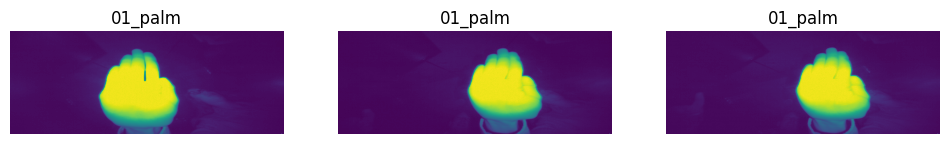

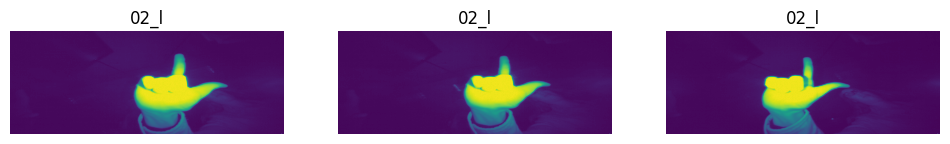

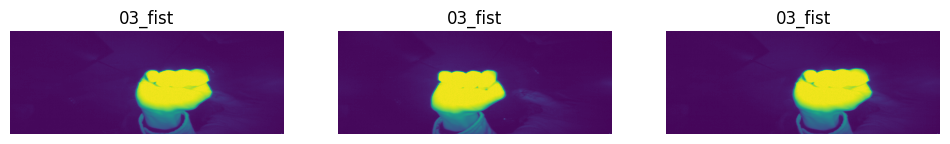

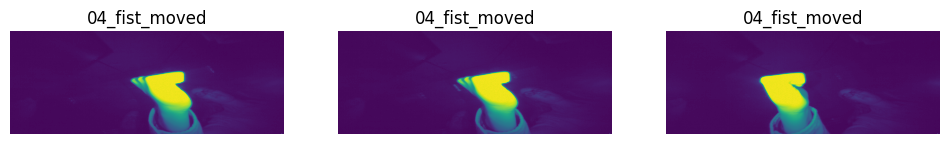

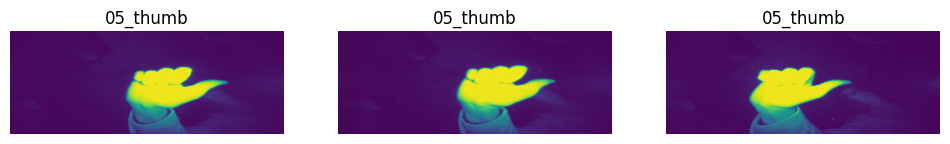

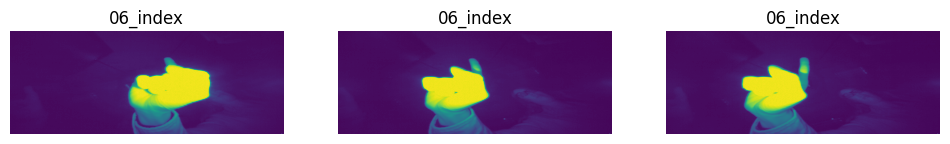

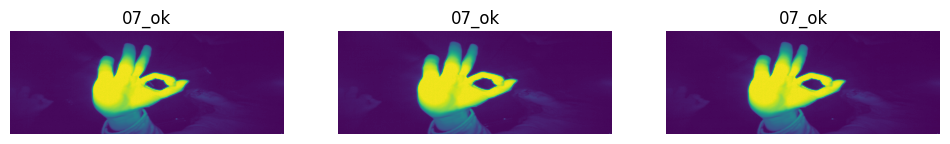

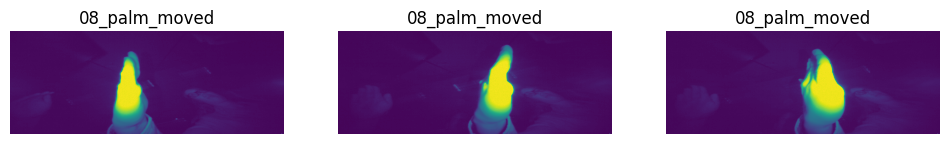

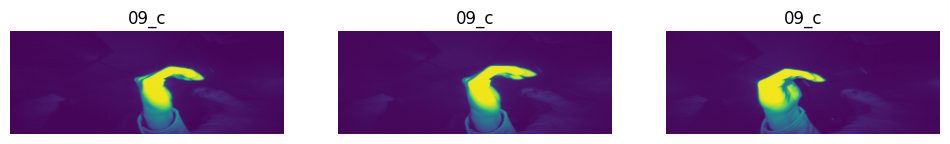

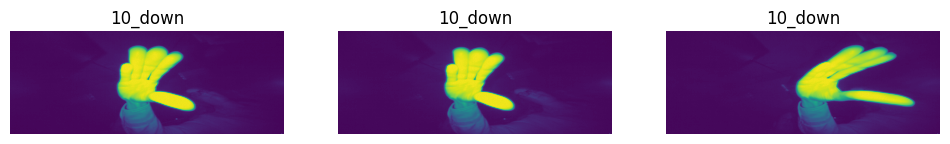


========================================01========================================


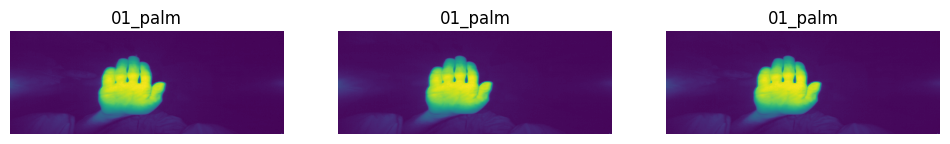

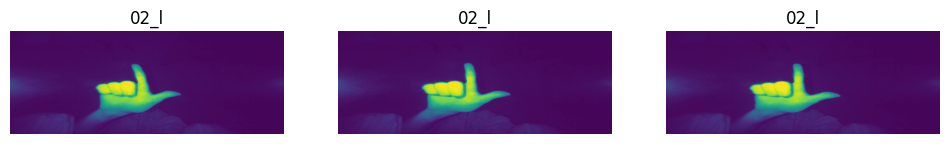

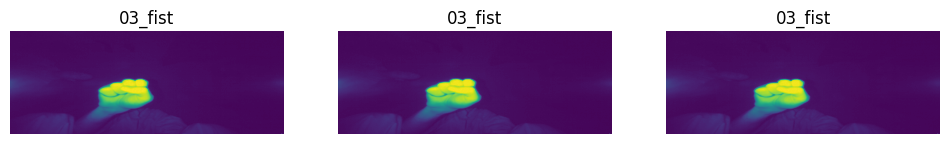

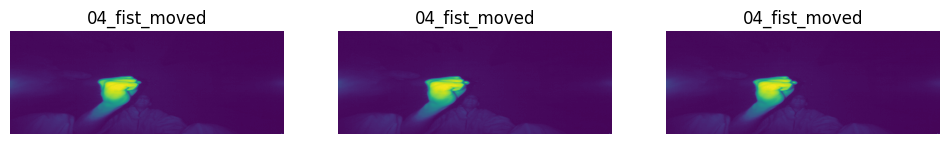

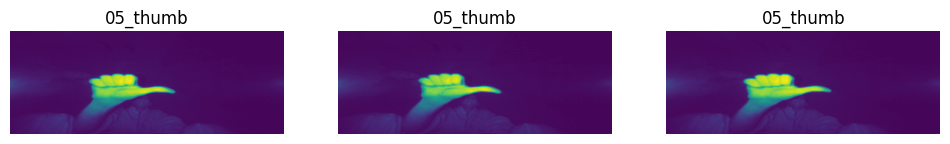

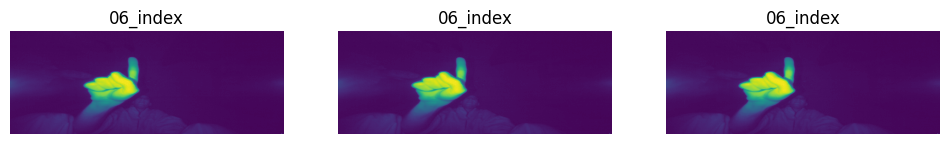

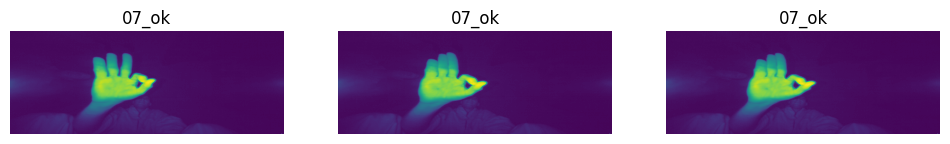

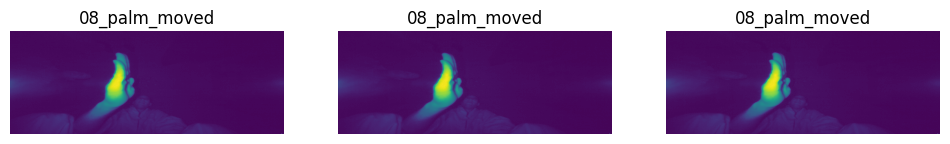

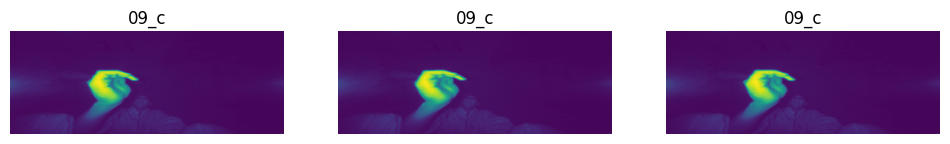

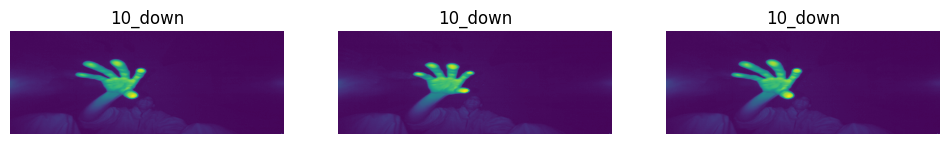


========================================02========================================


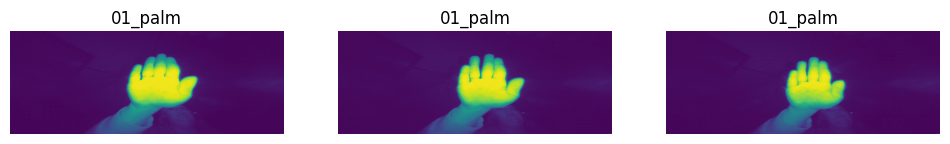

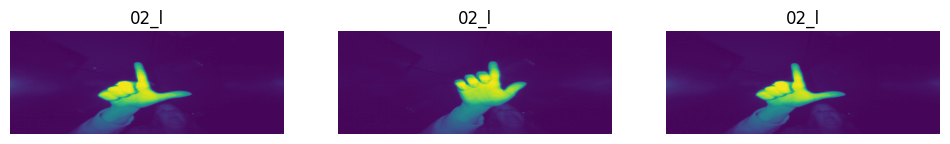

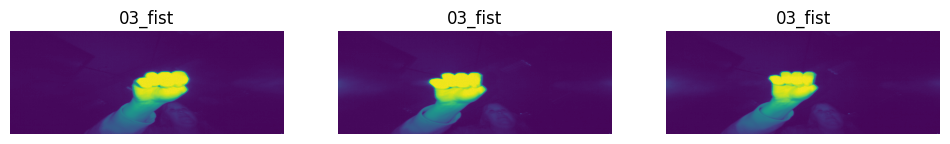

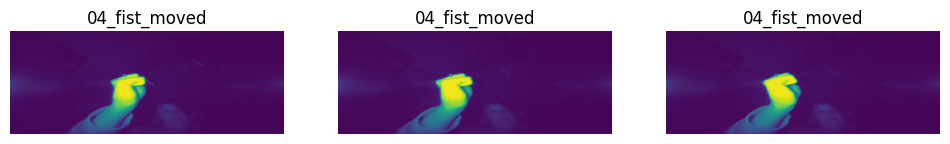

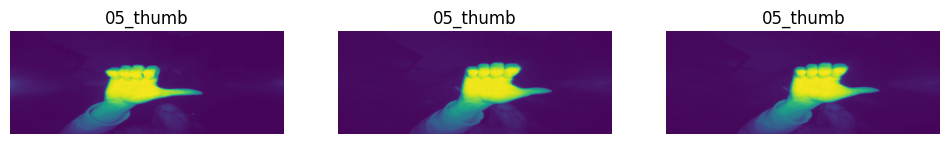

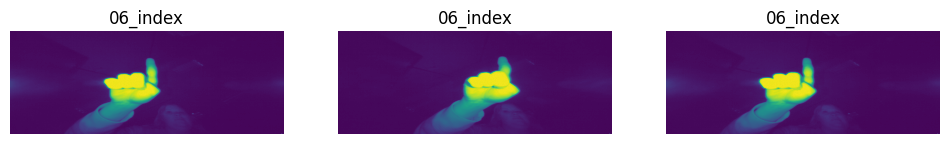

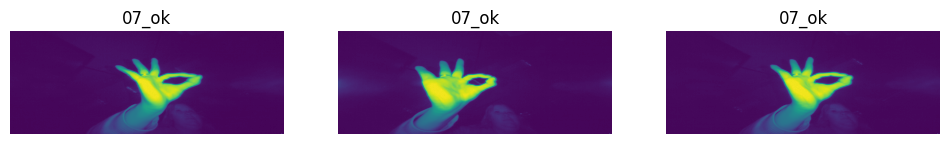

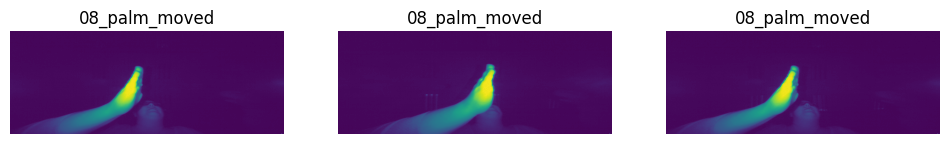

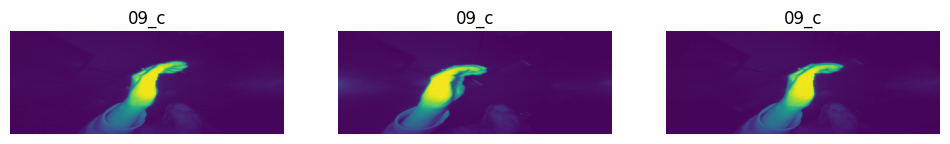

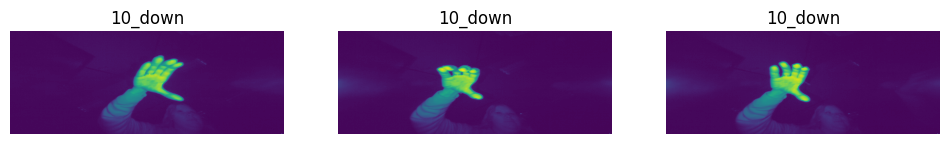


========================================03========================================


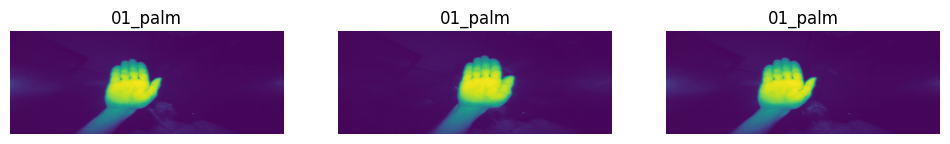

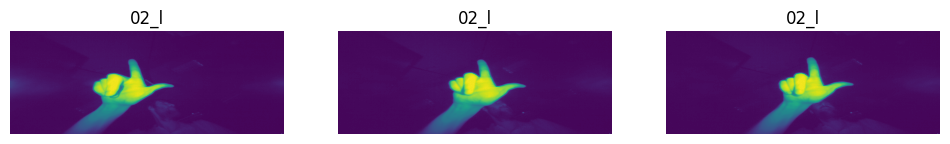

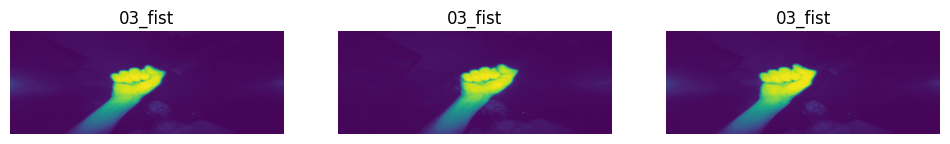

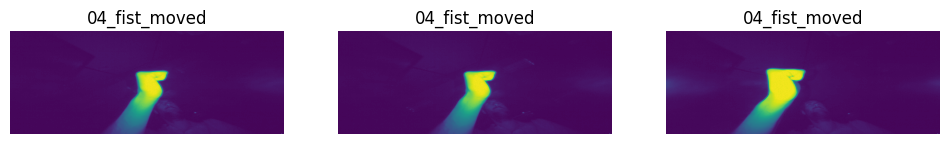

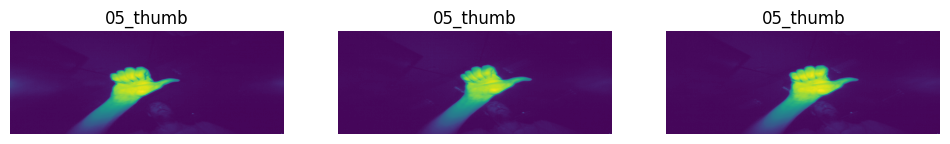

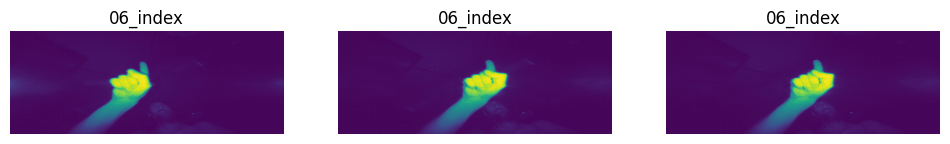

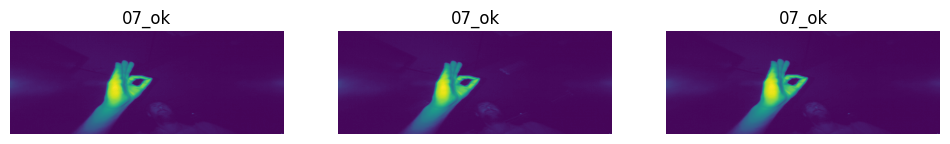

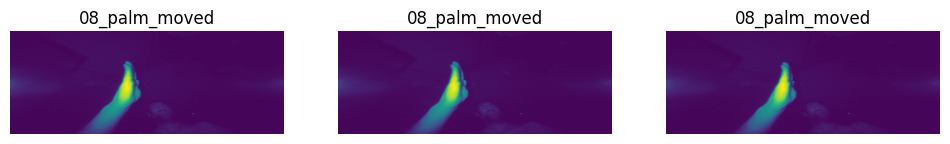

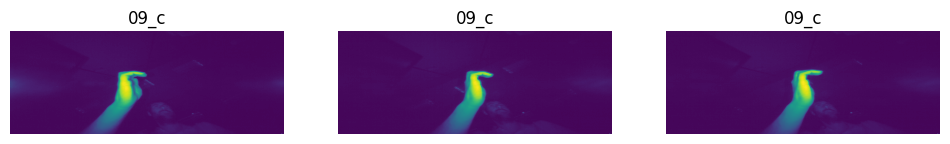

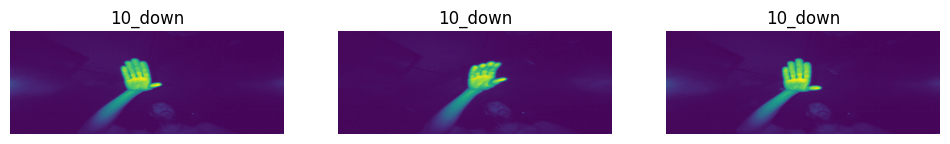


========================================04========================================


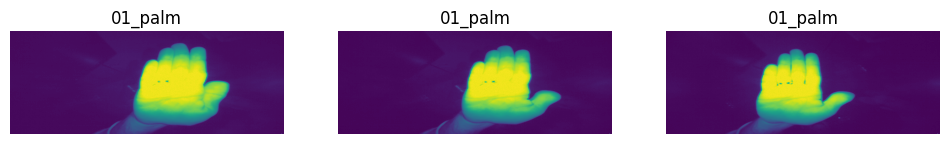

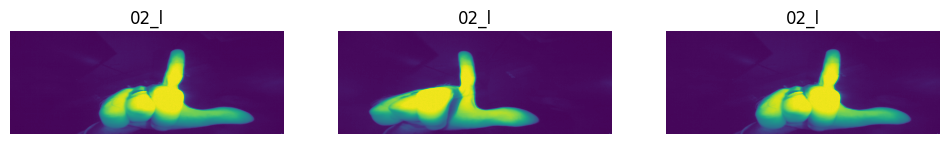

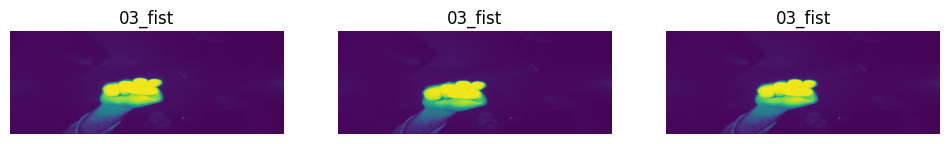

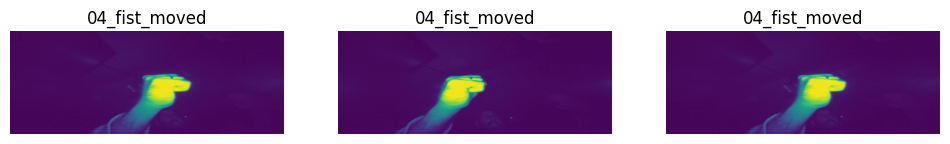

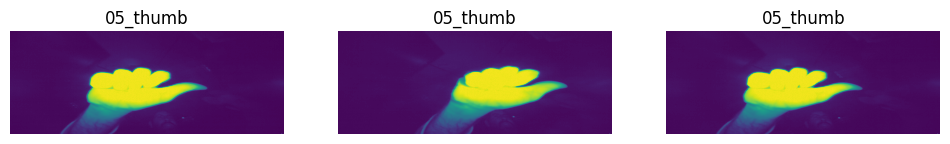

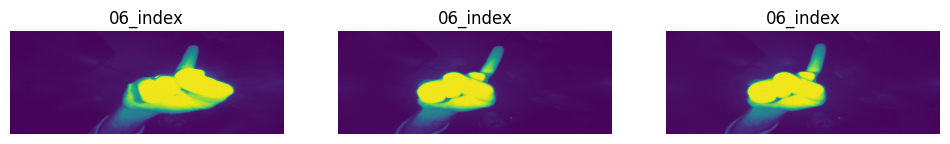

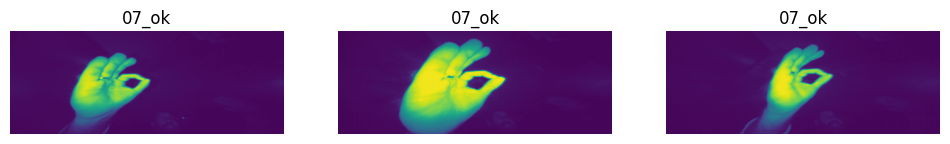

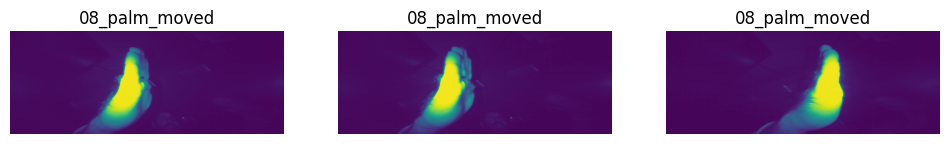

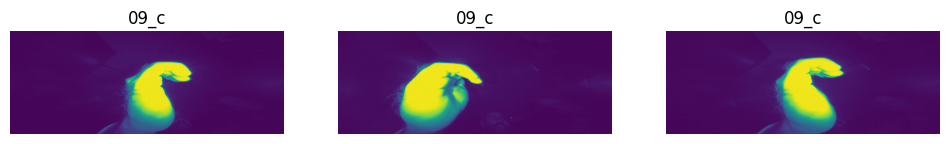

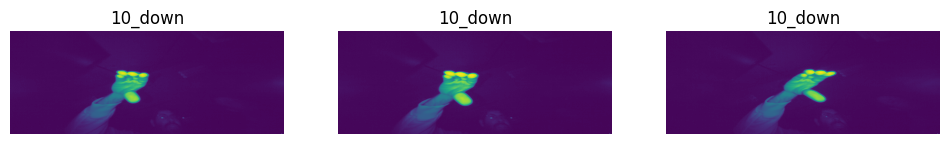


========================================05========================================


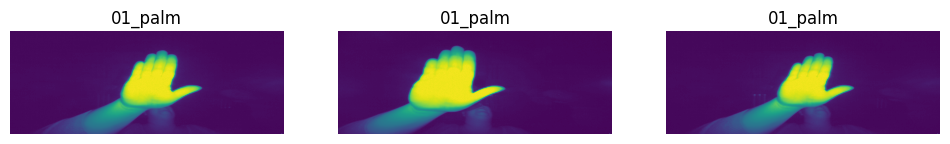

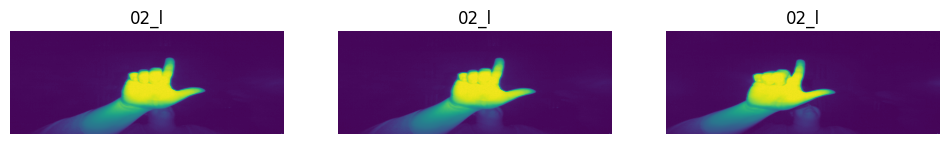

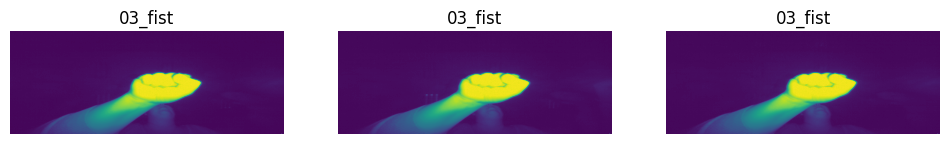

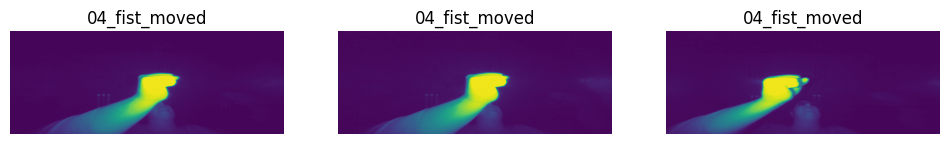

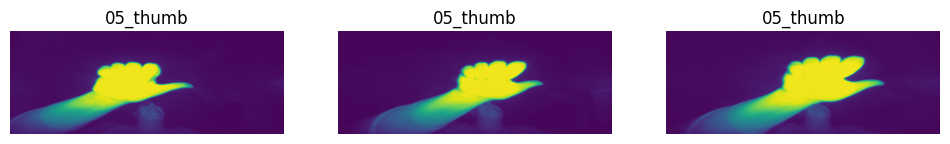

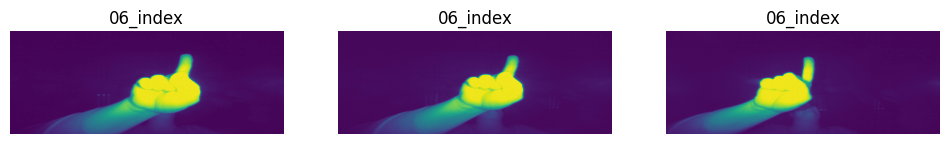

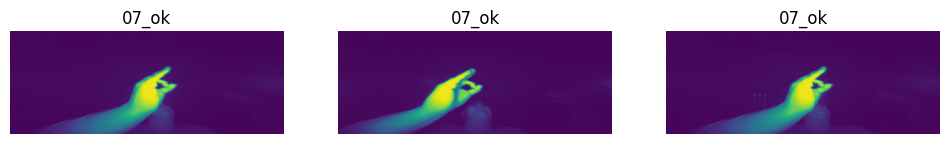

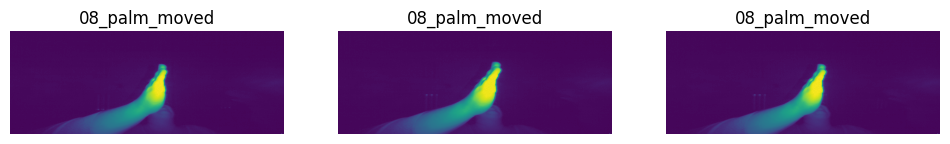

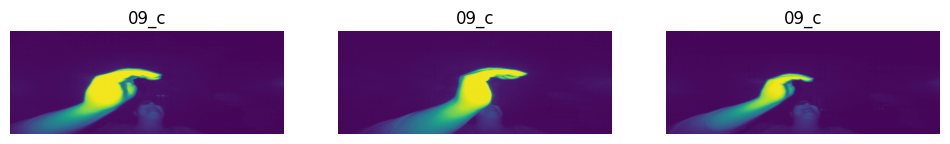

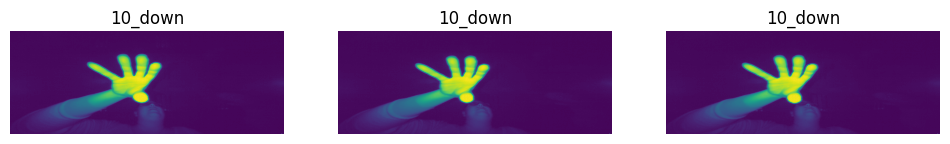


========================================06========================================


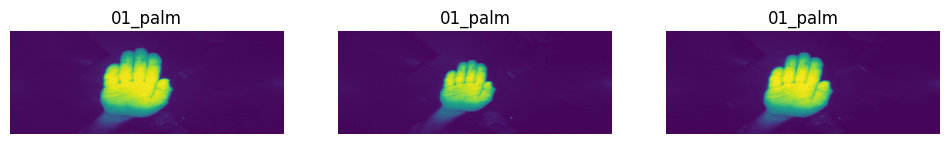

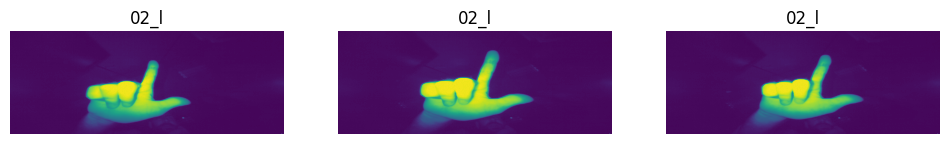

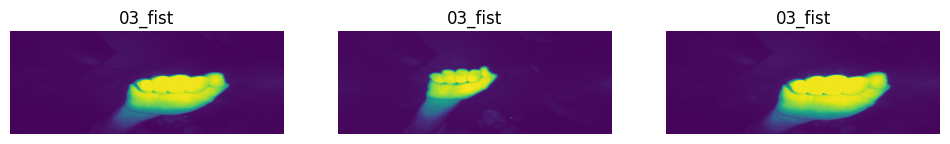

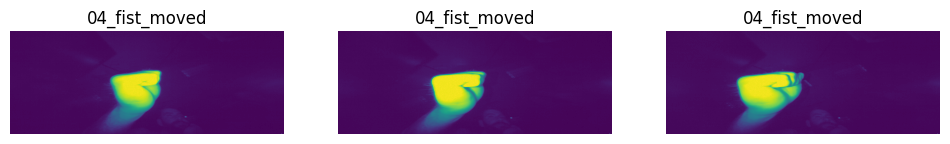

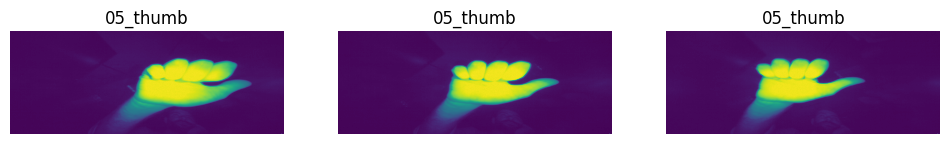

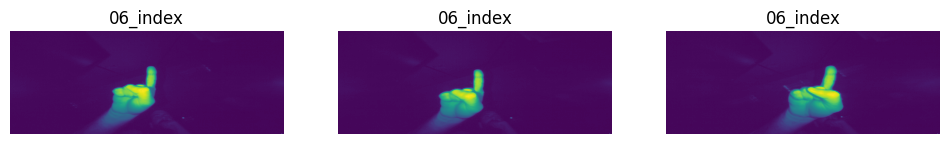

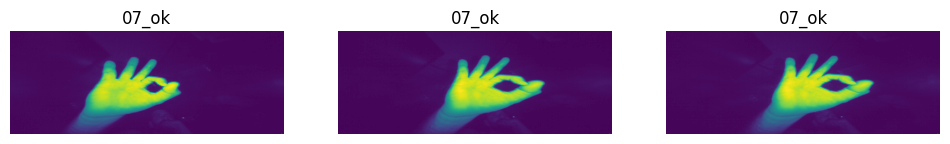

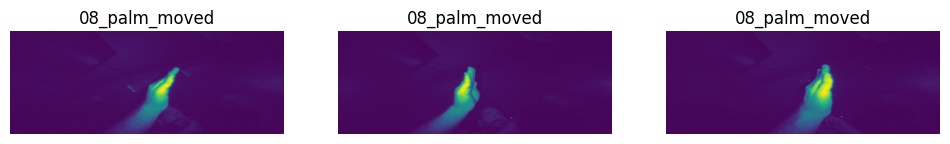

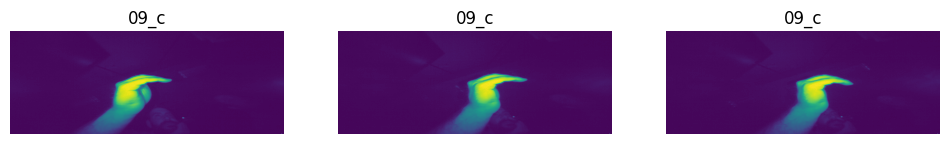

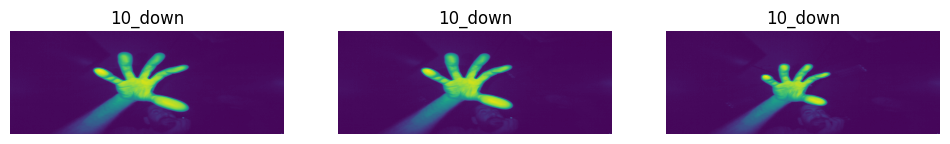


========================================07========================================


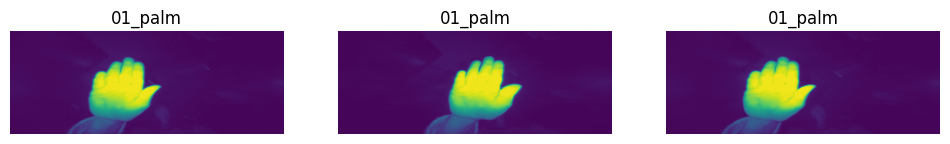

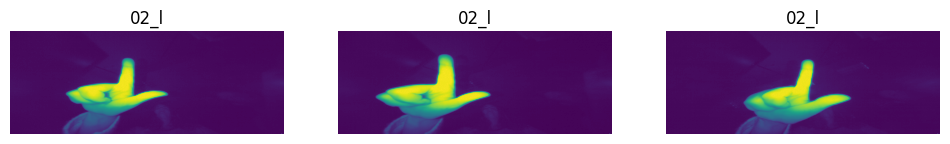

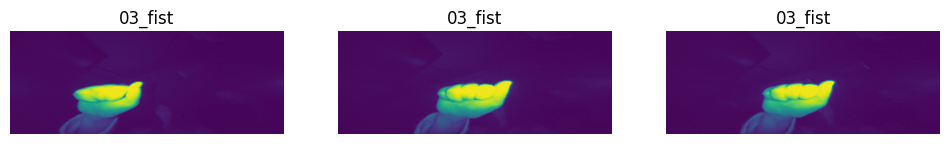

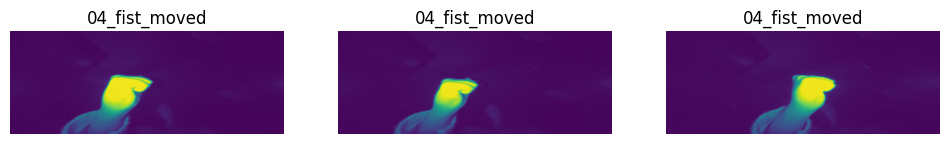

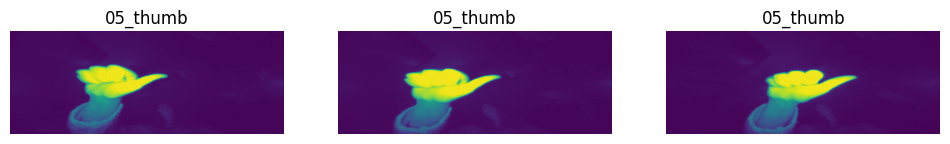

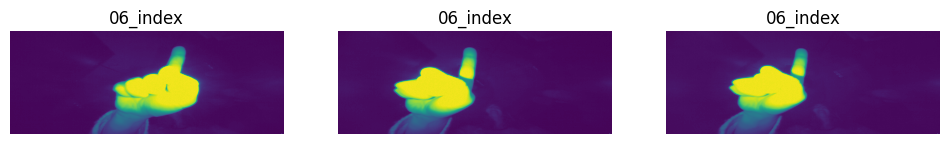

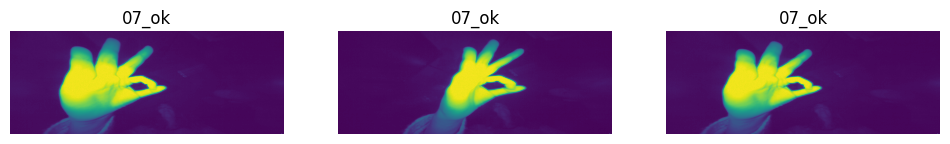

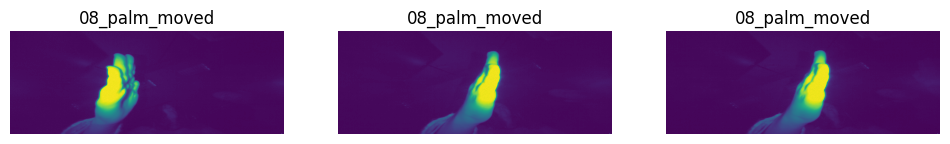

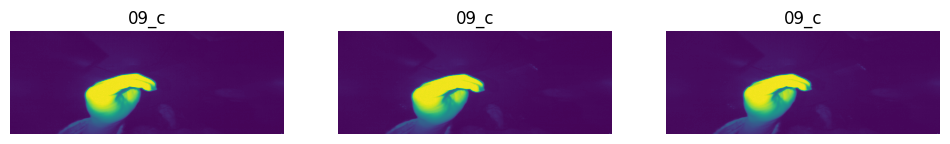

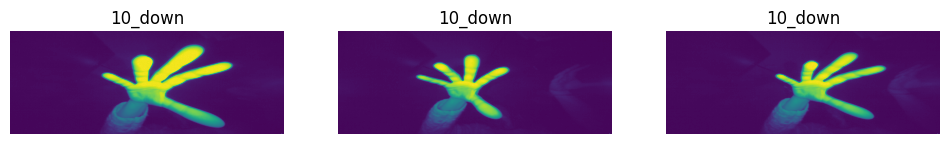


========================================08========================================


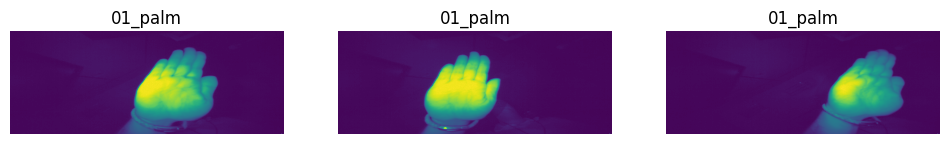

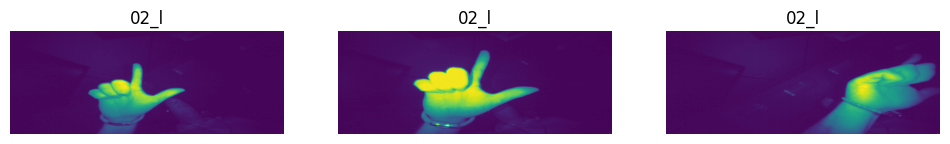

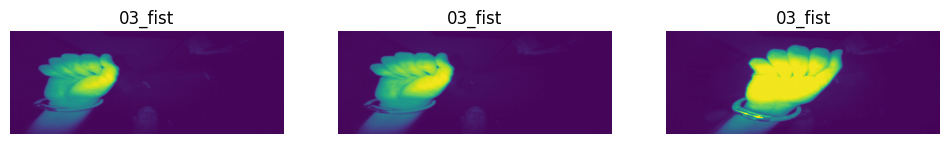

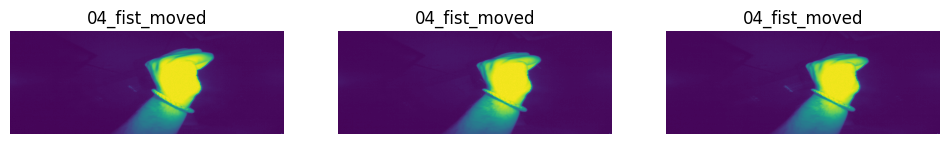

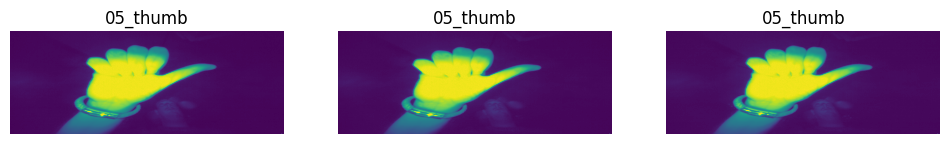

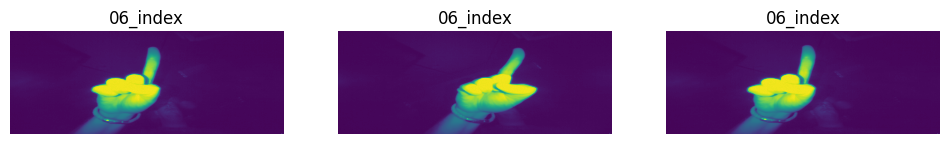

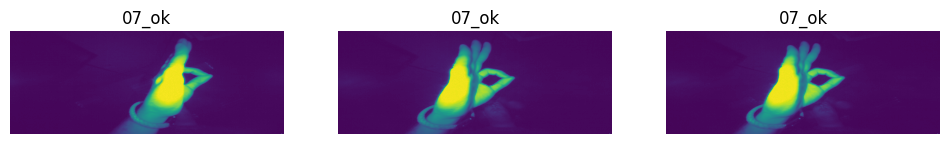

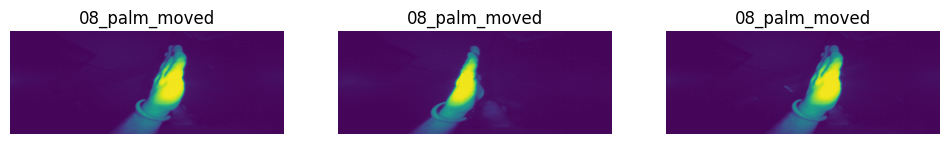

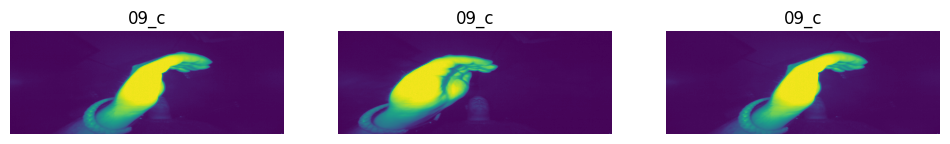

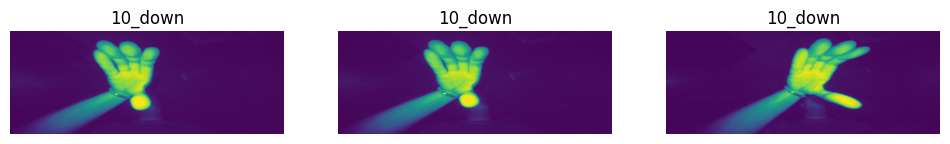


========================================09========================================


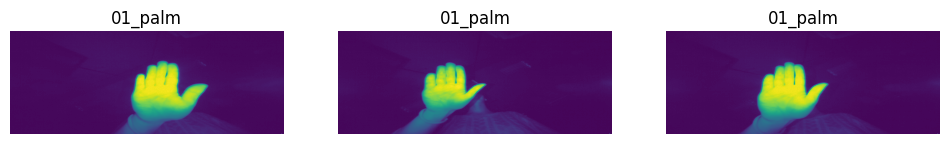

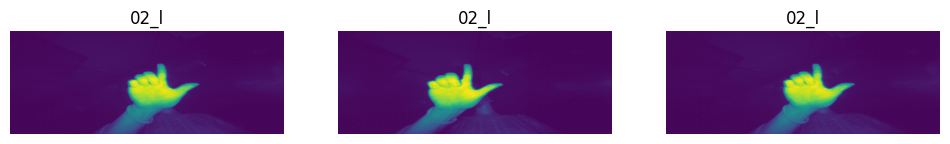

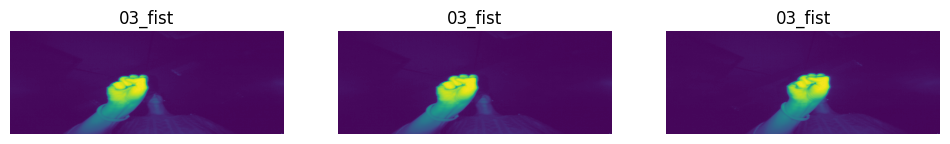

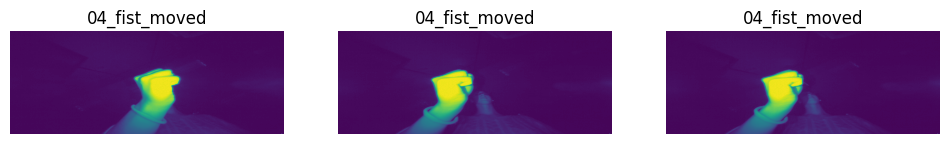

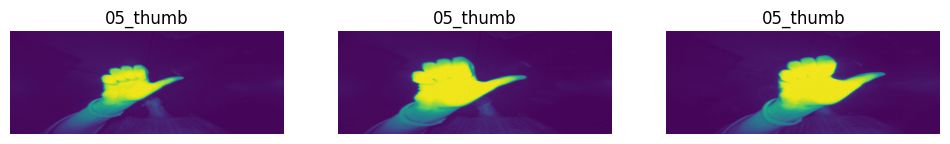

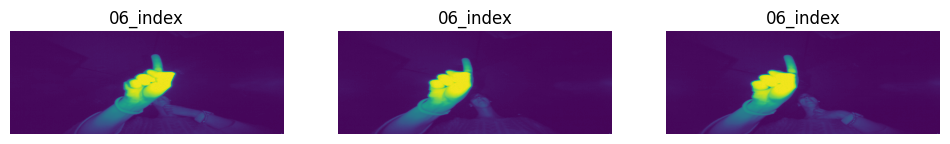

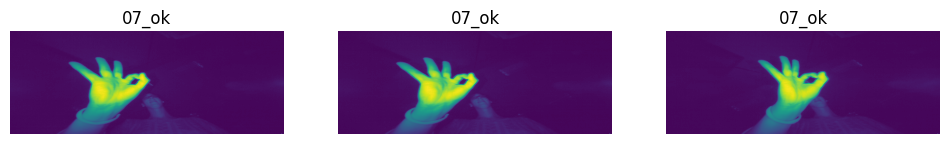

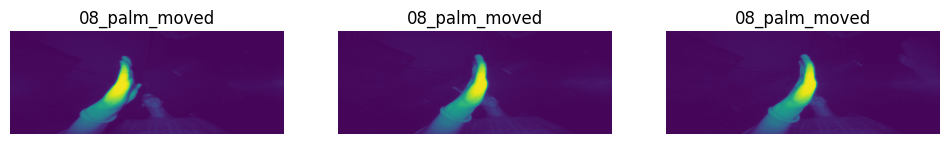

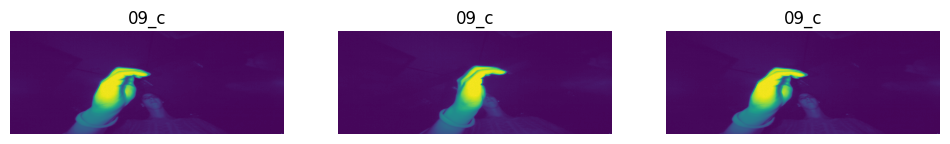

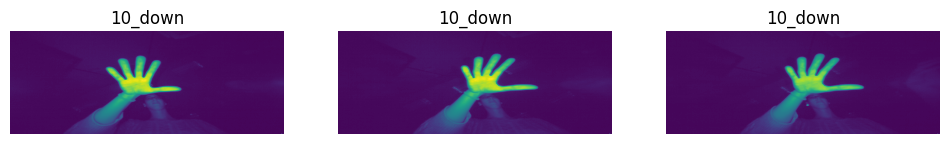

In [15]:
# Display 3 random images from subfolders of the root (CLASS), for each different
for subject in os.listdir(base_path):
  dir = os.path.join(base_path, subject)
  print(f'\n========================================{subject}========================================')
  for sub in gesture_folders:
    folder_path = os.path.join(dir, sub)
    image_files = os.listdir(folder_path)
    random_images = random.sample(image_files, 3)

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(random_images):
      plt.subplot(1, 3, i + 1)
      image_path = os.path.join(folder_path, image_file)
      image = mpimg.imread(image_path)
      plt.imshow(image)
      plt.axis('off')
      plt.title(f'{sub}')
    plt.show()


## Data Preprocessing

In [16]:
# Data Preprocessing (Creating a dataset for the training data)
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=25,         # Rotate the image by 25 degrees max
    width_shift_range=0.2,     # Shift the image horizontally by 20% max
    height_shift_range=0.2,    # Shift the image vertically by 20% max
    shear_range=0.2,           # Apply shearing transformations
    zoom_range=0.2,            # Randomly zoom
    horizontal_flip=True,      # Randomly flip the images horizontally
    fill_mode='nearest',       # Fill any missing pixels
    validation_split=0.2       # Use 20% of the data for validation
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,            # Only rescaling for validation set
    validation_split=0.2       # 20% validation split
)

In [17]:
# Define batch size
batch_size = 16

# Load training data
train_generator = train_datagen.flow_from_directory(
    base_path,                 # Path to dataset
    target_size=(256, 256),  # Resize the images
    batch_size=batch_size,     # Batch size
    class_mode='categorical',   # Labels are categorical
    subset='training',         # Use this for training data
    shuffle=True               # Shuffle the data
)

# Load validation data
validation_generator = valid_datagen.flow_from_directory(
    base_path,                 # Path to dataset
    target_size=(256, 256),  # Resize the images
    batch_size=batch_size,     # Batch size
    class_mode='categorical',   # Labels are categorical
    subset='validation',       # Use this for validation data
    shuffle=False              # No shuffling for validation
)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [18]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

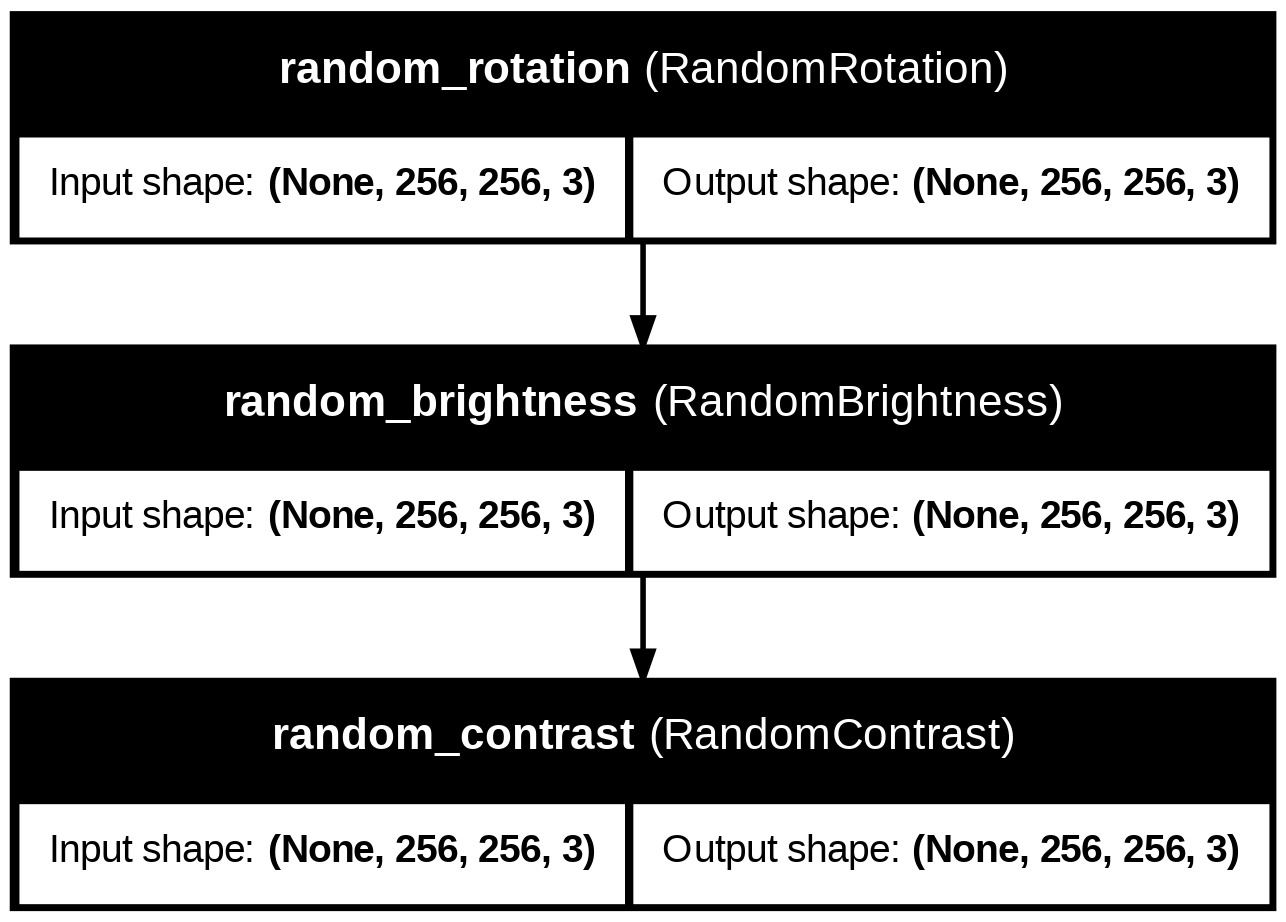

In [19]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

## Building a Convolutional Neural Network

### Layers used to the network

*   Convolution
*   Pooling
* Fully Connected
* Batch Normalization
* Dropout
* Flatten

In [20]:
# # Initiating model on GPU
with strategy.scope():
    # Build the Convolutional Neural Network (CNN)
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # First Conv Layer
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(256, 256, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Second Conv Layer
    model.add(Conv2D(64, (5,5), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Third Conv Layer
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fourth Conv Layer
    model.add(Conv2D(256, (5,5), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fifth Conv Layer
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Flatten the output of the conv layers
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(len(gesture_folders), activation='softmax')) # Classification layer

    # Compile the Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [21]:
# Callbacks for Early Stopping and Checkpointing
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_gesture.keras', monitor='val_accuracy', save_best_only=True)

# Train the Model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 439s 419ms/step - accuracy: 0.1193 - loss: 4.2863 - val_accuracy: 0.1000 - val_loss: 3.8842
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1273 - loss: 2.2827Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 424s 421ms/step - accuracy: 0.1444 - loss: 2.2427 - val_accuracy: 0.1000 - val_loss: 2.9197
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 420s 418ms/step - accuracy: 0.1605 - loss: 2.2001 - val_accuracy: 0.1930 - val_loss: 2.2422
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 400s 397ms/step - accuracy: 0.1691 - loss: 2.2139 - val_accuracy: 0.1650 - val_loss: 2.0725
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 408s 406ms/step - accuracy: 0.2120 - loss: 2.0547 - val_accuracy: 0.2075 - val_loss: 2.4667
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 431s 395ms/step - accuracy: 0.2480 - loss: 1.9702 - val_accuracy: 0.1417 - val_loss: 2.4063
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 399s 397ms/step - accuracy: 0.2738 - loss: 1.9128 - val_accuracy:

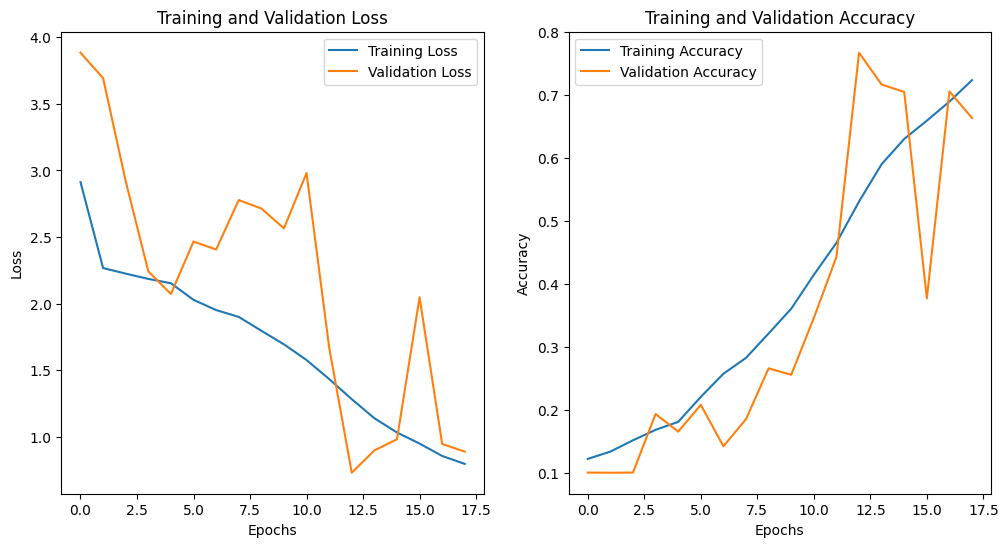

In [22]:
# Plot Training History
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The training loss shows a consistent decline, indicating that the model is learning and fitting the data well. However, the validation loss fluctuates, suggesting overfitting, particularly after around 10 epochs where the validation loss increases while the training loss continues to decrease. In terms of accuracy, the training accuracy steadily improves, whereas the validation accuracy shows significant variation, with some spikes and drops. This could be due to insufficient generalization, as the model performs better on the training data than on the unseen validation data. Overall, the model reaches around 72% validation accuracy but struggles with consistency across epochs.

In [23]:
# Load the best weights (from checkpoint)
model.load_weights('best_model_gesture.keras')

In [24]:
# Evaluate the model on the validation set

preds = model.predict(validation_generator)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation_generator) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.7947 - loss: 0.6533

Validation Loss:  0.7306511402130127

Validation Accuracy:  77.0 %
